# Masks

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
import pylab as pl

df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]
countries = ['Austria', 'UK', 'Germany', 'Italy', 'Czech', 'Switzerland']

In [38]:
def make_bin(df, npi, limit):
    data = df[npi]
    rows = [i for i in range(len(data)) if int(data[i]) >= limit]
    new_data = np.zeros_like(data)
    new_data[rows] = 1
    col_name = f'{npi}ed to {limit} or more'
    df[col_name] = new_data
    return df

mask_npi = CMs[8]
mask_limits = [2, 3, 4]

def make_all_bins(df, mask_lims):
    data = df
    for lim in mask_lims:
        data = make_bin(data, mask_npi, lim)
    return data

df = make_all_bins(df, mask_limits)
df = df.drop(columns=CMs[:20])
CMs = df.columns[5:]

In [39]:
def count_active_days_region(npi, country):
    df_country = df[df['Country']==country]
    #non_zero_rows = [ind for ind in range(df_country.shape[0]) if df_country[npi][ind] != 0]
    non_zero_rows = df_country[df_country[npi] != 0]
    regions = np.unique(df_country['Area'])
    active_inds = []
    for region in regions:
        #active_ind = [ind for ind in non_zero_rows if df_country['Area'][ind] == region]
        #active_ind = df_country.loc[df_country['Area'] == region]
        active_rows = non_zero_rows[non_zero_rows['Area']==region]
        count = active_rows.shape[0]
        active_inds.append(count)
    return regions, active_inds

active_days_uk = [count_active_days_region(npi, 'England')[1] for npi in CMs]
active_days_de = [count_active_days_region(npi, 'Germany')[1] for npi in CMs]
active_days_at = [count_active_days_region(npi, 'Austria')[1] for npi in CMs]
active_days_it = [count_active_days_region(npi, 'Italy')[1] for npi in CMs]
active_days_cz = [count_active_days_region(npi, 'Czech')[1] for npi in CMs]
active_days_ch = [count_active_days_region(npi, 'Switzerland')[1] for npi in CMs]
# summing up counts from the regions for each npi:
region_counts_uk = [sum(i) for i in active_days_uk]
region_counts_de = [sum(i) for i in active_days_de]
region_counts_at = [sum(i) for i in active_days_at]
region_counts_it = [sum(i) for i in active_days_it]
region_counts_cz = [sum(i) for i in active_days_cz]
region_counts_ch = [sum(i) for i in active_days_ch]

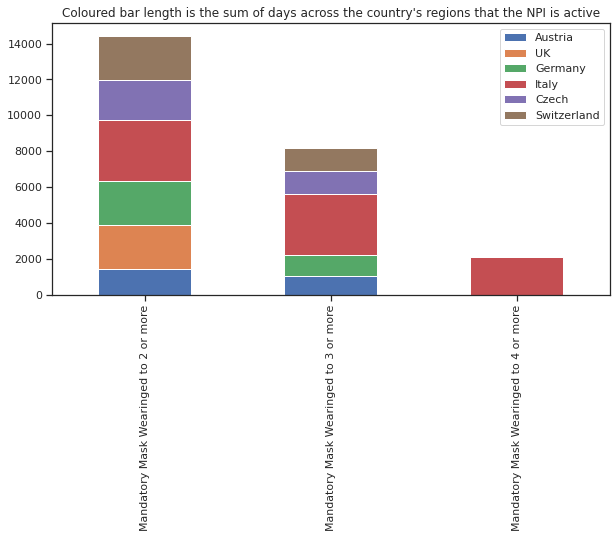

Text(0.5, 1.0, 'Active days attributable to each country')

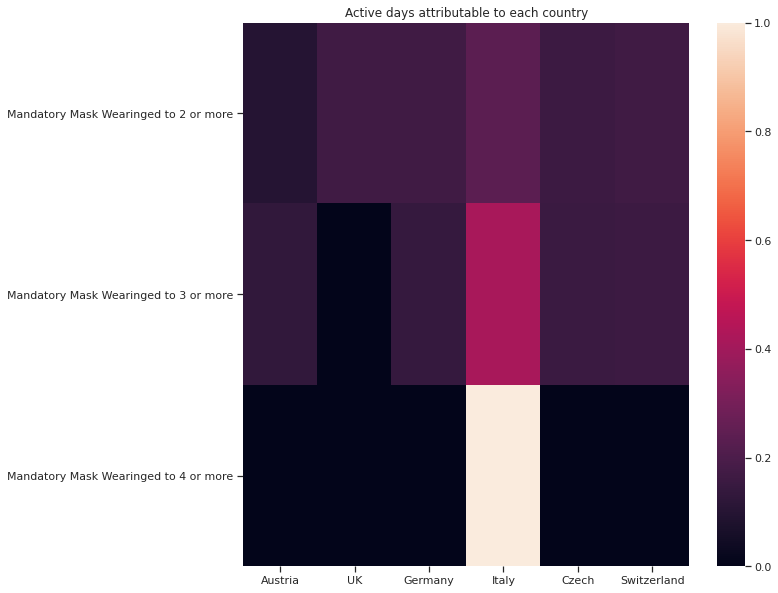

In [40]:
region_counts = pd.DataFrame((region_counts_at, region_counts_uk,
region_counts_de, region_counts_it, region_counts_cz, region_counts_ch)).T.set_index(CMs)
region_counts.columns = countries
region_counts.plot(kind='bar', stacked=True, title='Coloured bar length is the sum of days across the country\'s regions that the NPI is active', figsize = (10,5))
plt.show()
region_counts_normalised = region_counts.div(region_counts.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(region_counts_normalised, xticklabels = region_counts.columns, yticklabels = CMs, ax=ax).set_title('Active days attributable to each country')

# Retail closure, all non-essential businesses closed, stay-at-home order


In [35]:
df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]
df = df.drop(columns=CMs[:12])
df = df.drop(columns=CMs[15:])
CMs = df.columns[5:]

In [ ]:
def get_active_dates_region(data, npi):
    non_zero_dates = data['Date'][data[npi] != 0]
    return non_zero_dates

def intersect_npi_active_dates_region(active_days_1, active_days_2):
    return set(active_days_1).intersection(set(active_days_2))

def proportional_activation_region(active_days_1, active_days_2):
    number_of_active_days = len(active_days_1)
    if number_of_active_days == 0: return float('nan')
    number_of_jointly_active_days = len(intersect_npi_active_dates_region(active_days_1, active_days_2))
    return number_of_jointly_active_days/number_of_active_days

def activation_difference_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2))

def only_one_active_region(active_days_1, active_days_2):
    return len(set(active_days_1) - set(active_days_2)) + len(set(active_days_2) - set(active_days_1))

def find_conditional_activations(country):
    regions = np.unique(df['Area'][df['Country']==country])
    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    count = 0
    for region in regions:
        data = df[df['Area']==region]
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                active_days_1 = get_active_dates_region(data, CMs[i])
                active_days_2 = get_active_dates_region(data, CMs[j])
                if count == 0:
                    proportional_activations[i, j] = [proportional_activation_region(active_days_1, active_days_2)]
                    activation_differences[i, j] = [activation_difference_region(active_days_1, active_days_2)]
                    single_activations[i, j] = [only_one_active_region(active_days_1, active_days_2)]
                else:
                    proportional_activations[i, j].append(proportional_activation_region(active_days_1, active_days_2))
                    activation_differences[i, j].append(activation_difference_region(active_days_1, active_days_2))
                    single_activations[i, j].append(only_one_active_region(active_days_1, active_days_2))
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.mean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

def find_conditional_activations_total():

    proportional_activations = np.empty((len(CMs),len(CMs)), dtype=object)
    activation_differences = np.empty((len(CMs),len(CMs)), dtype=object)
    single_activations = np.empty((len(CMs),len(CMs)), dtype=object)

    countries = np.unique(df['Country'])
    count = 0
    for country in countries:
        prop, act, single = find_conditional_activations(country)
        for i in range(len(CMs)):
            for j in range(len(CMs)):
                if count == 0:
                    proportional_activations[i, j] = [prop[i,j]]
                    activation_differences[i, j] = [act[i,j]]
                    single_activations[i, j] = [single[i,j]]
                else:
                    proportional_activations[i, j].append(prop[i,j])
                    activation_differences[i, j].append(act[i,j])
                    single_activations[i, j].append(single[i,j])
        count += 1
    for i in range(len(CMs)):
        for j in range(len(CMs)):
            proportional_activations[i, j] = np.nanmean(proportional_activations[i, j])
            activation_differences[i, j] = np.sum(activation_differences[i, j])
            single_activations[i, j] = np.sum(single_activations[i, j])

    return proportional_activations, activation_differences, single_activations

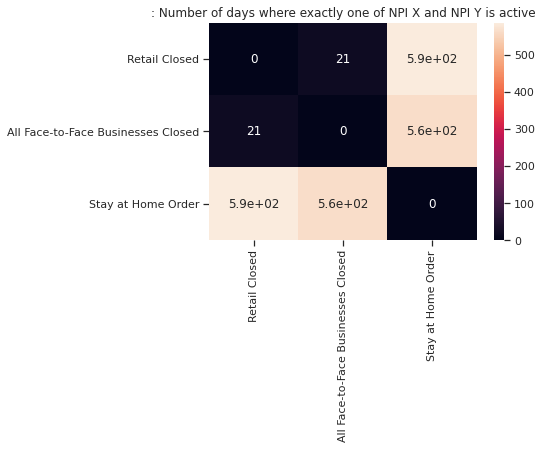

In [36]:
prop, act, single = find_conditional_activations_total()
sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs, annot = True).set_title(': Number of days where exactly one of NPI X and NPI Y is active')
plt.show()

# Education

In [33]:
df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]
df = df.drop(columns=CMs[:16])
CMs = df.columns[5:]


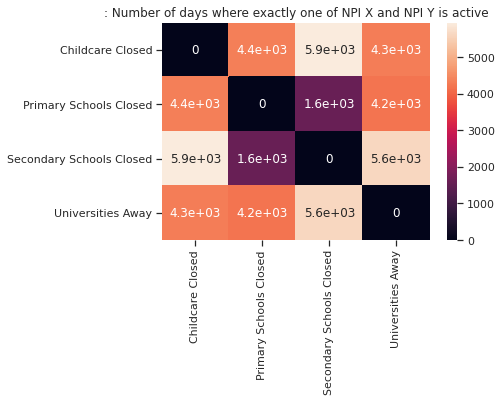

In [34]:
prop, act, single = find_conditional_activations_total()
sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs, annot = True).set_title(': Number of days where exactly one of NPI X and NPI Y is active')
plt.show()

# Gatherings

In [31]:
df = pd.read_csv('../data/all_merged_data.csv')
CMs = df.columns[5:]

def make_bin(df, npi, limit):
    data = df[npi]
    rows = [i for i in range(len(data)) if data[i] > 0 and data[i] <= limit]
    new_data = np.zeros_like(data)
    new_data[rows] = 1
    col_name = f'{npi}ed to {limit} or less'
    df[col_name] = new_data
    return df

gathering_npis = [CMs[i] for i in [0,1,2,3]]

def make_all_bins(df, gathering_lim):
    data = df
    for npi in gathering_npis:
        data = make_bin(data, npi, gathering_lim)
    return data

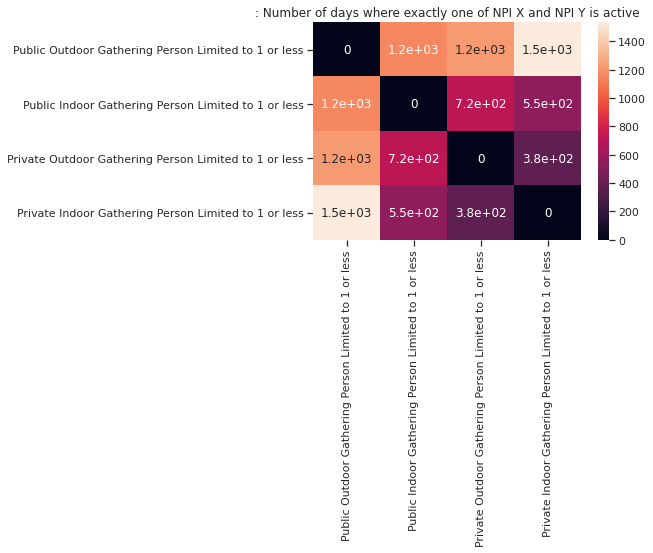

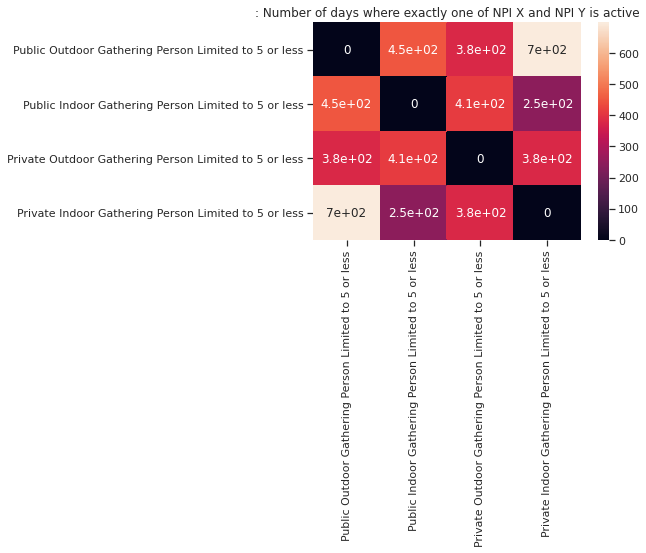

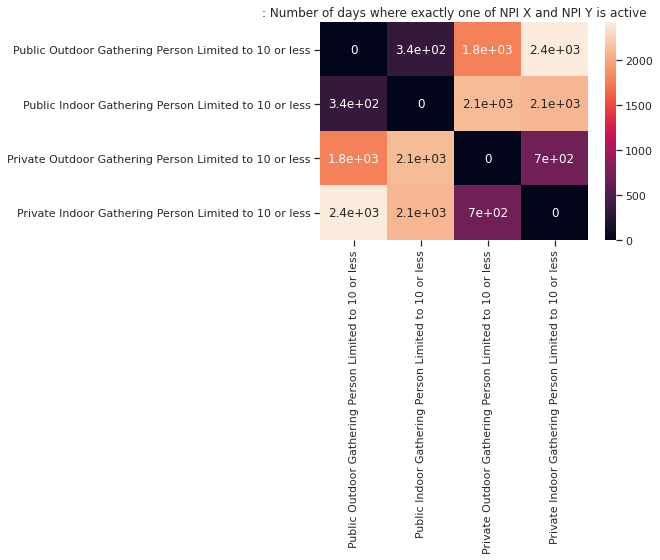

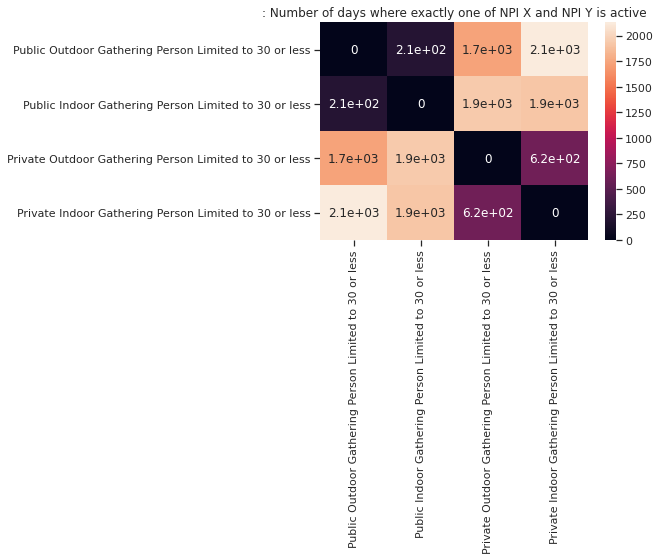

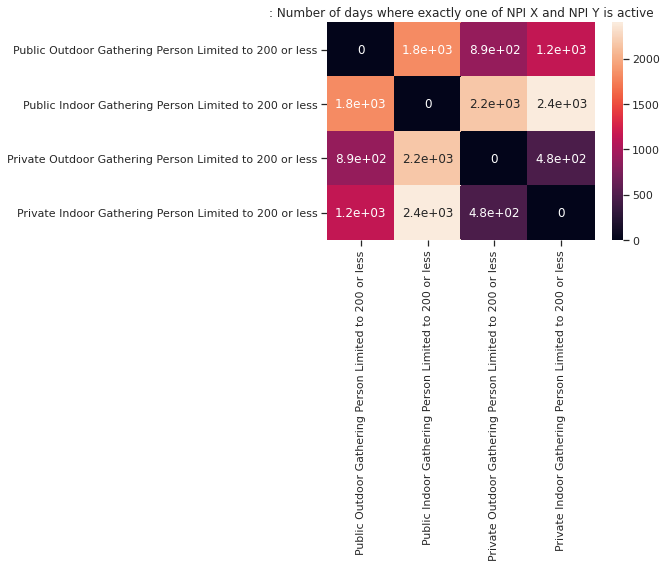

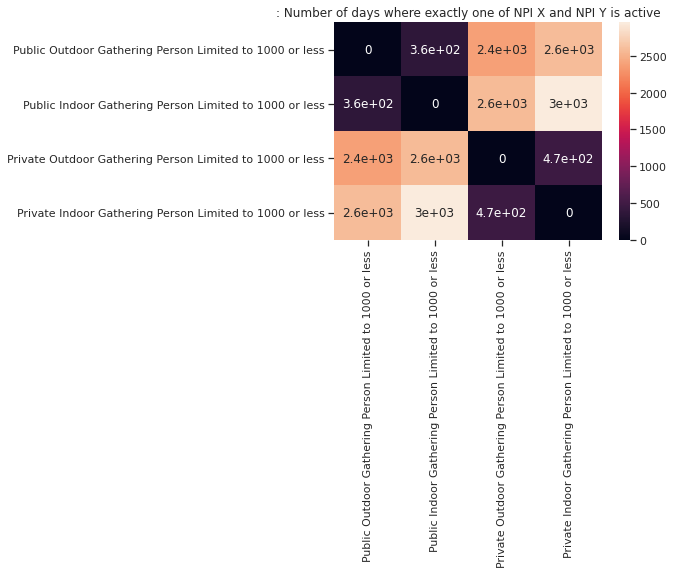

In [32]:
for i in range(len(gathering_limits)):
    df = make_all_bins(df, gathering_limits[i])
    df = df.drop(columns=CMs[:20])
    CMs = df.columns[5:]
    prop, act, single = find_conditional_activations_total()
    sns.heatmap(pd.DataFrame(single, dtype=float), xticklabels = CMs, yticklabels = CMs, annot = True).set_title(': Number of days where exactly one of NPI X and NPI Y is active')
    plt.show()
    df = pd.read_csv('../data/all_merged_data.csv')
    CMs = df.columns[5:]